In [107]:
import sys

sys.path.insert(0, '../src/SynBIoModules')

In [109]:
from model import ResLinear

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import torch
from Bio import SeqIO
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
import scipy as spy
from transformers import AutoModel, AutoTokenizer

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [93]:
TRAINING_SEQS_PATH = '../data/training_seqs.csv'

In [94]:
training_seqs = pd.read_csv(TRAINING_SEQS_PATH)

array([[<Axes: title={'center': 'Brightness'}>]], dtype=object)

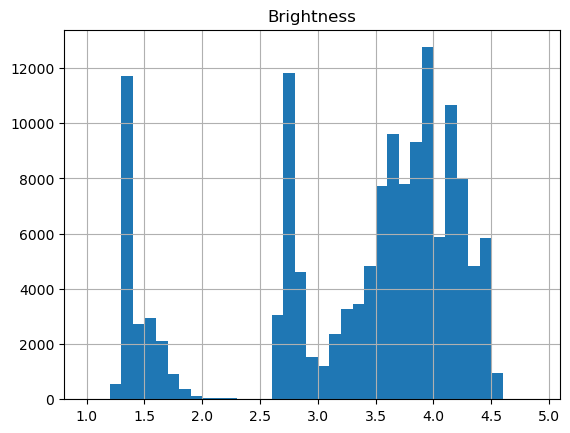

In [95]:
training_seqs.hist('Brightness', bins=np.arange(1, 5, 0.1))

In [96]:
from sklearn.cluster import KMeans

kmeans = KMeans(2, max_iter=300)
kmeans.fit(training_seqs["Brightness"].to_numpy().reshape(-1, 1))

center_between_clusters = kmeans.cluster_centers_.mean()

In [97]:
training_seqs.loc[:, 'cluster'] = (training_seqs['Brightness'] < center_between_clusters).astype(int)

<Axes: xlabel='Brightness', ylabel='Count'>

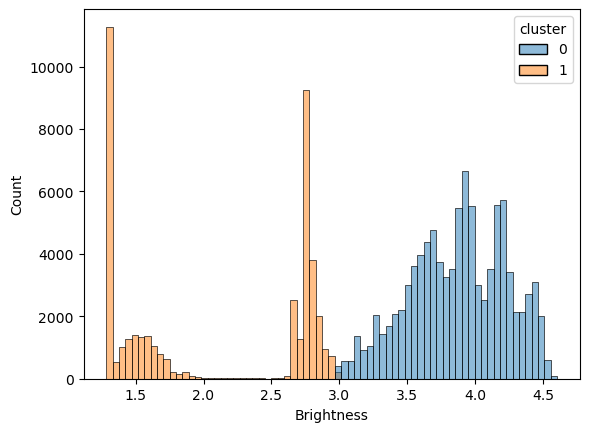

In [98]:
sns.histplot(data=training_seqs, x='Brightness', hue='cluster')

In [99]:
regression_df = training_seqs.query('cluster == 0')

In [100]:
regression_df

,aaMutations,GFP type,Brightness,mut_seqs,cluster
0,WT,avGFP,3.719212,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0
4,A109G,avGFP,3.708478,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0
5,A109G:K139M:R167C:L235P,avGFP,3.582764,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0
7,A109G:K157R,avGFP,3.659013,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0
8,A109G:K157R:I160V:I187V:T224S,avGFP,3.573855,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0
...,...,...,...,...,...
141170,T128A:V150A:S158P,ppluGFP,4.035788,MPAMKIECRITGTLNGVEFELVGGGEGTPEQGRMTNKMKSTKGALT...,0
141171,E122K:S171P:V196A,ppluGFP,4.096312,MPAMKIECRITGTLNGVEFELVGGGEGTPEQGRMTNKMKSTKGALT...,0
141172,G22D,ppluGFP,4.068633,MPAMKIECRITGTLNGVEFELVDGGEGTPEQGRMTNKMKSTKGALT...,0
141173,G107C:S171T:T203A,ppluGFP,3.939097,MPAMKIECRITGTLNGVEFELVGGGEGTPEQGRMTNKMKSTKGALT...,0


In [ ]:
model_checkpoint = "facebook/esm2_t33_650M_UR50D"

In [77]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
embedding_model = AutoModel.from_pretrained(model_checkpoint).to(device)
sequences = regression_df['mut_seqs'].to_list()

NameError: name 'model_checkpoint' is not defined

In [ ]:
tokens = tokenizer(sequences, return_tensors="pt", padding=True)

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset



# Custom dataset
class SequenceDataset(Dataset):
    def __init__(self, tokens):
        self.tokens = tokens

    def __len__(self):
        return len(self.tokens['input_ids'])

    def __getitem__(self, idx):
        return self.tokens['input_ids'][idx], self.tokens['attention_mask'][idx]
               
    

# Create dataset and dataloader
batch_size = 256
dataset = SequenceDataset(tokens)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


all_embeddings = []
for input_ids, attention_mask in tqdm(dataloader, total=len(sequences) // batch_size):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outputs = embedding_model(input_ids, attention_mask)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        del outputs
        all_embeddings.append(embeddings.cpu())
        del embeddings


final_embeddings = torch.cat(all_embeddings, dim=0)

In [ ]:
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(
    final_embeddings,
    regression_df["Brightness"].to_numpy(),
    test_size=0.3,
    shuffle=True,
)

X_val, X_test, y_val, y_test = sk.model_selection.train_test_split(
    X_val, y_val, test_size=0.5, shuffle=True
)

In [ ]:
from torch.utils.data import DataLoader, Dataset


class RegressionDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        """Возвращает размер датасета."""
        return self.features.shape[0]

    def __getitem__(self, idx):
        """Возвращает один элемент датасета по индексу."""
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)


train_dataset = RegressionDataset(X_train, y_train)

val_dataset = RegressionDataset(X_val, y_val)

test_dataset = RegressionDataset(X_test, y_test)

In [ ]:
BUTCH_SIZE = 50000

train_dataloader = DataLoader(train_dataset, batch_size=BUTCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BUTCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BUTCH_SIZE, shuffle=True)

In [ ]:
import torch.optim as optim


def train_model(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    criterion,
    device,
    num_epochs=100,
    writer=None,
):
    model.train()  # Устанавливаем модель в режим обучения
    for epoch in tqdm(range(num_epochs), total=num_epochs):
        running_loss = 0
        for features, targets in train_dataloader:
            targets = targets.to(device)
            optimizer.zero_grad()  # Обнуление градиентов
            features = features.to(device)
            outputs = model(features)
            # outputs = outputs.to("cpu")
            loss = criterion(outputs.squeeze(), targets)  # Вычисление потерь
            running_loss += loss
            loss.backward()  # Обратный проход
            optimizer.step()  # Обновление параметров

        if writer:
            avg_loss = running_loss / len(train_dataloader)
            writer.add_scalar("Avg Training Loss per Epoch", avg_loss, epoch)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
        if (epoch + 1) % 10 == 0:
            validate_model(model, val_dataloader, criterion, device, writer, epoch)


# Функция для валидации модели
def validate_model(model, dataloader, criterion, device, writer=None, epoch=None):
    model.eval()  # Устанавливаем модель в режим валидации
    total_loss = 0
    with torch.no_grad():  # Отключаем вычисление градиентов
        for features, targets in dataloader:
            targets = targets.to(device)
            features = features.to(device)
            outputs = model(features)
            # outputs = outputs.to("cpu")  # Прямой проход
            loss = criterion(outputs.squeeze(), targets)  # Вычисление потерь
            total_loss += loss.item()  # Суммируем потери
    av_loss = total_loss / len(dataloader)
    print(f"Validation Loss: {av_loss:.4f}")
    if writer and epoch:
        writer.add_scalar("val Loss", av_loss, epoch)

In [ ]:
learning_rate = 0.00002
weight_decay = 0.00001
model = ResLinear(1280, 10).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=False)
criterion = torch.nn.L1Loss()

In [ ]:
writer = SummaryWriter("runs/regression_model")
train_model(
    net, train_dataloader, val_dataloader, optimizer, criterion, device, 30000, writer
)
writer.close()